In [20]:
### Import the different libraries
## Keras libraries are used for the DNN
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
import scipy.io
import math
import matplotlib.pyplot as plt
import time

# Parameters

In [21]:
# Number of episodes
n_games = 50

max_mem_size = 4000 #GOTO 10 000 if RAM available

K = 4 #Nb of users

target_rate_outage = [0.2]*K
target_delay_outage = [0.2]*K

### Files
users_infos_filename = 'MATLAB/ressources/users_infos_K4.mat'
los_filename = 'MATLAB/ressources/topologies/topo_3x3/4users/nLoS.mat'

In [22]:
%run Schedulers.ipynb

Users Infos:
[[1.00000000e+00 8.56963734e-01 9.72183169e-01 8.11777547e-01]
 [1.00000000e+08 5.00000000e+07 5.00000000e+08 1.00000000e+07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.00000000e+00 5.00000000e+00 3.00000000e+00 4.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05]] 



# Replay Buffer

In [23]:
## DQN's buffer
class ReplayBuffer(object):
    
    def __init__(self, max_size, input_shape, n_actions, discrete = True):
        self.mem_size = max_size
        self.input_shape = input_shape
        self.discrete = discrete
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        
        dtype = np.int32 if self.discrete else np.float32
        self.action_memory = np.zeros(self.mem_size, dtype = dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.float32)
        
    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
            #if self.discrete:
            #Discretize // Find discrete representation of actions
            #actions = np.zeros(self.action_memory.shape[1])
            #actions[action] = 1.0
            #self.action_memory[index] = actions
            #else:
        self.action_memory[index] = action
        self.mem_cntr +=1
    
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        
        states = self.state_memory[batch]
        next_states = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        
        return states, actions, rewards, next_states, terminal


## Function to build the neural network
def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims, fc3_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims, )),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(fc3_dims),
                Activation('relu'),
                Dense(n_actions)])
    model.compile(optimizer = Adam(lr = lr), loss ='mse')
    
    return model


### Function to transform an integer to a binary action (vector of 1 and 2, 1 = Sub-6 GHz and 2 = mmWave)
def to_binary(val):
    arr = []
    while val:
        val, r = divmod(val,2)
        arr.append(r)
    arr = np.flip(arr)
    to_ret = np.append(np.zeros(K - len(arr)), arr).astype(int)
    to_ret = to_ret + 1
    return to_ret.tolist()


### Create a ternary action from an integer value (vector of 0, 1 or 2)
def to_ternary(val):
    arr = []
    while val:
        val, r = divmod(val,3)
        arr.append(r)
    arr = np.flip(arr)
    to_ret = np.append(np.zeros(K - len(arr)), arr).astype(int)
    
    return to_ret.tolist()

# DRL Agent

In [24]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                    input_dims, epsilon_dec=0.99, epsilon_end=0.01,
                    mem_size = max_mem_size, fname_input='models/dqn_model_K8.h5', fname_output='models/dqn_model_K8_pretrained.h5'):
        self.action_space = np.arange(n_actions) # Might Have to change with action representation        self.gamma = gamma
        self.random_actions_queue = np.arange(n_actions)
        np.random.shuffle(self.random_actions_queue)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file_input = fname_input
        self.model_file_output = fname_output
        
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                    discrete = True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 128, 128, 64)
        
    ## Remember in the DQN's buffer the transitions
    def remember(self, state, action, reward, next_state, done):
        self.memory.store_transition(state, action, reward, next_state, done)
     
    
    #### Epsilon greedy method to choose the action
    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            print('random action with epsilon: ', self.epsilon)
            action = np.random.choice(self.action_space)   
            
        else:
            print('predicted action with epsilon: ', self.epsilon)
            actions = self.q_eval.predict(state)
            action = np.argmax(actions[0]) # Maybe actions[0] 
        return action
    
    ## Update the DNN
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        if self.memory.mem_cntr > 3*self.batch_size:
            self.batch_size = 2*self.batch_size
        
        state, action, reward, next_state, done = self.memory.sample_buffer(self.batch_size)
        
        action_indices = action
        
        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(next_state)
        
        q_target = q_eval.copy()
        
        batch_index = np.arange(self.batch_size, dtype = np.int32)
        
        q_target[batch_index, action_indices] = reward + self.gamma*np.amax(q_next, axis = 1)*done
        
        
        _ = self.q_eval.fit(state, q_target, verbose = 0)
        
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min
        
    def save_model(self):
        self.q_eval.save(self.model_file_output)
    
    def load_model(self):
        self.q_eval = load_model(self.model_file_input)
        


# Environment

In [25]:
class Environment(object):
    ## Initialization
    def __init__(self, users_infos_filename, los_filename, target_rate_relab, target_delay_relab):
        self.actions_taken = 0
        self.infos_filename = users_infos_filename
        self.los_filename = los_filename
        ## Rate and delay requirements
        self.users_rate_requirement = np.ravel(scipy.io.loadmat(self.infos_filename)['users_infos'][1], order = 'F')
        self.users_delay_requirement = np.ravel(scipy.io.loadmat(self.infos_filename)['users_infos'][3], order = 'F')
        
        ### State Space, rate and delay reliability of each user (in the paper, Section 5, I described it as the outage probability and both of the outage or reliab work) (vector of size 2*K) 
        self.users_infos = np.zeros(2*K)
        print(self.users_infos)
        self.total_users = int(np.size(self.users_infos)/2)
        
        ## Rate and delay reliability targets
        self.target_rate_relab = 1 - np.array(target_rate_relab)
        self.target_delay_relab = 1 - np.array(target_delay_relab)
        self.rate_outage_history = []
        self.delay_outage_history = []

        ## reward weights (Equ. 16 and 17)
        self.weights = np.ones(K*2)
        
        ## Variables used to count the number of time an action has been chosen
        self.action_zero = np.zeros(K)
        self.action_one = np.zeros(K)
        self.action_two = np.zeros(K)
        
        ## Used to remember the achieved rate/delay per frame and per user
        self.rate_perPeriod = []
        self.delay_perPeriod = []
        
    ## Reset all values at the end of an episode
    def reset(self):
        self.actions_taken = 0
        self.users_infos = np.zeros(2*K)
        print(self.users_infos)
        self.total_users = int(np.size(self.users_infos)/2)  #Can Maybe Comment this line
        self.weights = np.ones(K*2)
        
        self.rate_outage_history = []
        self.delay_outage_history = []
        
        self.action_zero = np.zeros(K)
        self.action_one = np.zeros(K)
        self.action_two = np.zeros(K)
        
        return self.users_infos
    
    
        
    # Run Matlab code for given action as argument    
    def step(self, action, iter_epoch):
        self.actions_taken = self.actions_taken + 1
        print(self.actions_taken)
        ternary_action = to_binary(action) ## Create the action vector
        ### Count the number of times an action has been chosen
        for idx, val in enumerate(ternary_action):
            if val == 0:
                self.action_zero[idx] += 1
            elif val == 1:
                self.action_one[idx] += 1
            else:
                self.action_two[idx] += 1
        print(ternary_action)
        
        # matlab_action = matlab.int32(ternary_action)
        
        ### Call the matlab optimization code, 
        ''' Output: 
        achieved : average achieved rate over the 10 frames per user,
        rate_probas : average rate outage probability over the 10 frames per user,
        delay_probas : average delay outage probability over the 10 frames per user,
        avg_delay : average delay over the 10 frames,
        time_opti : optimization time,
        total_achieved : achieved rate per frame,
        total_delay : achieved delay per frame
        '''
        
        #### CHANGER ICI, CETTE FONCTION UTILISAIT MATLAB MAIS IL FAUT MAINTENANT FAIRE APPEL A LA FONCTION PYTHON
        ## On aura qqch comme: 
        achieved, rate_probas, delay_probas, avg_delay, time_opti, total_achieved, total_delay = scheduler(ternary_action, iter_epoch, self.actions_taken)

        # achieved, rate_probas, delay_probas, avg_delay, time_opti, total_achieved, total_delay = eng.main_function_K4_N4(matlab_action, los_filename, i+1, self.actions_taken, nargout = 7)
        # achieved, rate_probas, delay_probas, avg_delay, time_opti = eng.main_function_K4_N4(matlab_action, los_filename, i+1, self.actions_taken, nargout = 7)
        
        print('achieved: \n', achieved)
        print('rate_probas: \n', rate_probas)
        print('delay_probas: \n', delay_probas)
        print('average delay: \n', avg_delay)
        print('time opti: \n', time_opti)
        
        ach = np.asarray(achieved)
        ### Compute the reliability (1 - outage proba)
        relab_rate = 1 - np.asarray(rate_probas[0])
        relab_delay = 1 - np.asarray(delay_probas[0])
        delay = np.asarray(avg_delay[0])
        
        self.rate_outage_history.append(np.asarray(rate_probas[0]))
        self.delay_outage_history.append(np.asarray(delay_probas[0]))
        
        total_achieved = np.asarray(total_achieved)
        total_delay = np.asarray(total_delay)
        self.rate_perPeriod.append(total_achieved)
        self.delay_perPeriod.append(total_delay)
        
        ### Update the state space (rate and delay reliability values)
        self.users_infos[0::2] = relab_rate
        self.users_infos[1::2] = relab_delay
        
        ## Compute the reward and update the weights as described in the paper
        reward = - np.sum( self.weights[0::2] * (1 - relab_rate) + self.weights[1::2] * (1 - relab_delay))
        self.weights[0::2] = np.maximum(0, self.weights[0::2] + self.target_rate_relab - relab_rate)
        self.weights[1::2] = np.maximum(0, self.weights[1::2] + self.target_delay_relab - relab_delay)

        print('users_infos updated: \n', self.users_infos)
        print('updated weights:')
        print(self.weights[0::2])
        print(self.weights[1::2])
        
        print('Outage means for this period: rate: ', np.mean(np.asarray(rate_probas[0])), ' and delay: ', np.mean(np.asarray(delay_probas[0])))
        print('Outage means for this epoch: rate: ', np.mean(self.rate_outage_history), ' and delay: ', np.mean(self.delay_outage_history))
    

        '''
        Condition for the last term of the reward : 
        boolean, check if the mean of the rate and delay reliability are greater than a threshold (\gamma* in the paper)
        '''
        success_rate = np.mean(relab_rate) >= 0.9
        success_delay = np.mean(relab_delay) >= 0.9

        ### Success condition (Equ. 18)
        success = success_rate or success_delay
        print("Delay: ", success_delay, " and Rate: ", success_rate)
        ## if done = 1, stop the episode. Done = 1 if the success condition is achieved or if we performed 40 learning periods
        # done = 1 if self.actions_taken >= 20  else success
        done = 1 if self.actions_taken >= 39  else 0
        # reward += success*1000
        print('Reward: \n', reward)
        
        return self.users_infos, reward, done, ach, time_opti

# Main 

In [26]:
agent = Agent(gamma = 0.1, epsilon = 1, epsilon_dec=0.99, alpha = 0.1, input_dims = 2*K,
                  n_actions = (2**K)-1, mem_size = max_mem_size, batch_size=64, epsilon_end = 0.01)


## Create the environment
env = Environment(users_infos_filename, los_filename, target_rate_outage, target_delay_outage)

## Initialize the different arrays to remember the results
total_reward_history = []
avg_reward_history = []
avg_sum_rate = []
max_sum_rate = []
eps_history = []
actions_until_done = []
rate_outage = []
delay_outage = []

time_history_DQN = []
time_history_Opti = []

action_zero_history = []
action_one_history = []
action_two_history = []

## Start an episode
for i in range(n_games):
    print('\n This is a New Episode STARTING: \n')
    
    ## Start time to get the execution time
    ## Initialize the parameters at the beginning of an episode
    start_time = time.time()
    time_opti_periode = 0
    done = False
    total_reward = 0
    sum_rate = []
    observation = env.reset()
    
    ## For 40 periods or while the condition of Eq. 18 is not reached
    while not done:
        
        ## Choose an action (with the epsilon greedy method)
        action = agent.choose_action(observation)
        next_observation, reward, done, info, time_opti = env.step(action, i) # TODO CREATE THIS 
        ## Remember the different information
        time_opti_periode += time_opti
        total_reward += reward
        sum_rate.append(sum(info))
        ### Remember the transition in the DQN's buffer
        agent.remember(observation, action, reward, next_observation, done)
        observation = next_observation
        ## Update the DNN
        agent.learn()
    
    ### Remember the different information at the end of an episode, I just use it to create the plots
    eps_history.append(agent.epsilon)
    total_reward_history.append(total_reward)
    avg_sum_rate.append(np.mean(sum_rate))
    max_sum_rate.append(np.max(sum_rate))
    actions_until_done.append(env.actions_taken)
    rate_outage.append(np.mean(env.rate_outage_history, axis = 0))
    delay_outage.append(np.mean(env.delay_outage_history, axis = 0))
    
    ## Compute and remember the total execution time, the learning time and the optimization time
    period_time_DQN = time.time() - start_time - time_opti_periode
    time_history_DQN.append(period_time_DQN)
    time_history_Opti.append(time_opti_periode)
    
    ## Remember the chosen actions
    action_zero_history.append(env.action_zero)
    action_one_history.append(env.action_one)
    action_two_history.append(env.action_two)

        
    ## Compute and remember the average reward 
    avg_reward = np.mean(total_reward_history[max(0, i - 20):(i+1)])
    avg_reward_history.append(avg_reward)
    print('episode ', i, 'score %.2f' % total_reward, 'average score %.2f' % avg_reward)
    

[0. 0. 0. 0. 0. 0. 0. 0.]

 This is a New Episode STARTING: 

[0. 0. 0. 0. 0. 0. 0. 0.]
random action with epsilon:  1
1
[2, 2, 2, 1]
achieved: 
 [6.65132311e+07 3.62400867e+07 3.62400867e+07 4.46688865e+08]
rate_probas: 
 [1. 1. 1. 0.]
delay_probas: 
 [1. 0. 1. 1.]
average delay: 
 [6. 1. 6. 6.]
time opti: 
 0.1093440055847168
users_infos updated: 
 [0. 0. 0. 0. 0. 0. 0. 0.]
updated weights:
[1.8 1.8 1.8 1.8]
[1.8 1.8 1.8 1.8]
Outage means for this period: rate:  1.0  and delay:  1.0
Outage means for this epoch: rate:  1.0  and delay:  1.0
Delay:  False  and Rate:  False
Reward: 
 -8.0
random action with epsilon:  1
2
[2, 2, 2, 1]
achieved: 
 [6.65132311e+07 3.62400867e+07 3.62400867e+07 4.46688865e+08]
rate_probas: 
 [1. 1. 1. 0.]
delay_probas: 
 [1. 0. 1. 1.]
average delay: 
 [6. 1. 6. 6.]
time opti: 
 0.20462989807128906
users_infos updated: 
 [0. 0. 0. 0. 0. 0. 0. 0.]
updated weights:
[2.6 2.6 2.6 2.6]
[2.6 2.6 2.6 2.6]
Outage means for this period: rate:  1.0  and delay:  1.0
Out

In [27]:
## The rest of the notebook is just used to plot and save the different graphs 

print('epsilon history through episodes: \n', eps_history)

print('\n score history through episodes: \n', total_reward_history)

print('\n Number of actions taking each episodes: \n', actions_until_done)

print('\n Average score for past 10 episodes: \n', avg_reward_history)

print('\n Average sum rate through episodes: \n', avg_sum_rate)

print('\n Maximum achieved sum rate through episodes: \n', max_sum_rate)

print('\n Average Rate Outage for every user: \n', np.mean(rate_outage, axis = 0))

print('\n Average Delay Outage for every user: \n', np.mean(delay_outage, axis = 0))

print("\n Total exec. time: \n", np.sum(time_history_DQN) + np.sum(time_history_Opti))

epsilon history through episodes: 
 [1, 0.8600583546412883, 0.5811664141181095, 0.392711028357805, 0.2653662497477053, 0.17931568359471056, 0.1211688163570484, 0.08187728905270841, 0.055326862671220584, 0.03738596830031274, 0.02526278480776821, 0.017070797554767782, 0.011535233798383842, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

 score history through episodes: 
 [-3262.4000000000005, -3244.0, -2873.600000000001, -2722.400000000001, -2530.4000000000015, -2527.200000000001, -2529.6000000000013, -2530.400000000001, -2529.600000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, -2527.200000000001, 

In [28]:
avg_sum_rate_Mbit = np.array(avg_sum_rate) / 1e+6
max_sum_rate_Mbit = np.array(max_sum_rate) / 1e+6

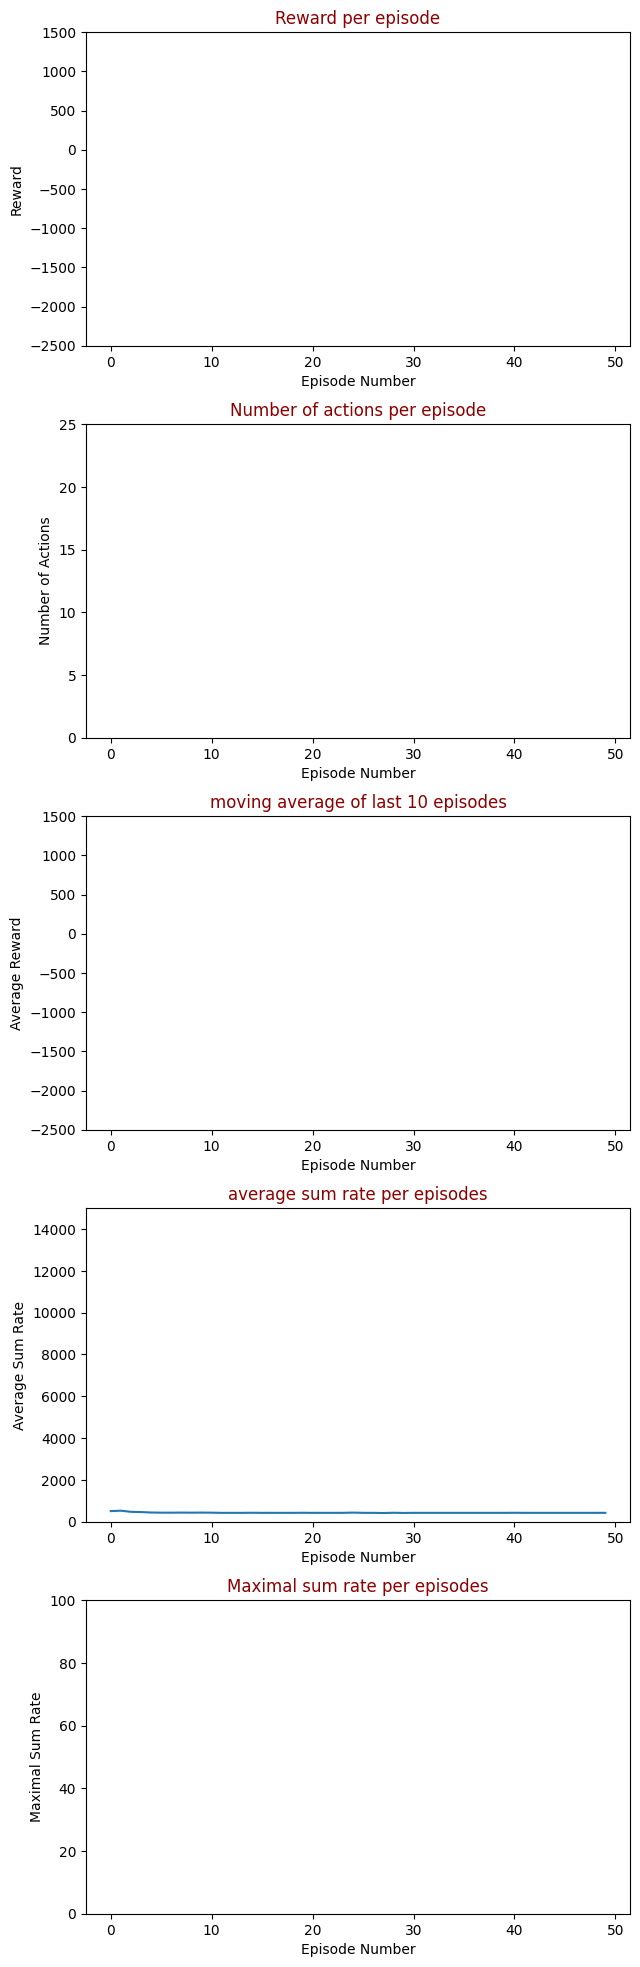

In [29]:
fig = plt.figure()

plt.subplot(511)
plt.plot(total_reward_history)
plt.ylim(-2500, 1500)
plt.title('Reward per episode', color = 'darkred')
plt.ylabel('Reward')
plt.xlabel('Episode Number')

plt.subplot(512)
plt.plot(actions_until_done)
plt.ylim(0, 25)
plt.title('Number of actions per episode', color = 'darkred')
plt.ylabel('Number of Actions')
plt.xlabel('Episode Number')

plt.subplot(513)
plt.plot(avg_reward_history)
plt.ylim(-2500, 1500)
plt.title('moving average of last 10 episodes', color = 'darkred')
plt.ylabel('Average Reward')
plt.xlabel('Episode Number')

plt.subplot(514)
plt.plot(avg_sum_rate_Mbit)
plt.ylim(0, 15000)
plt.title('average sum rate per episodes', color = 'darkred')
plt.ylabel('Average Sum Rate')
plt.xlabel('Episode Number')

plt.subplot(515)
plt.plot(max_sum_rate)
plt.ylim(0, 100)
plt.title('Maximal sum rate per episodes', color = 'darkred')
plt.ylabel('Maximal Sum Rate')
plt.xlabel('Episode Number')


plt.subplots_adjust(top=4, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

0.0041025641025641026
1.0
0.0041025641025641026
1.0


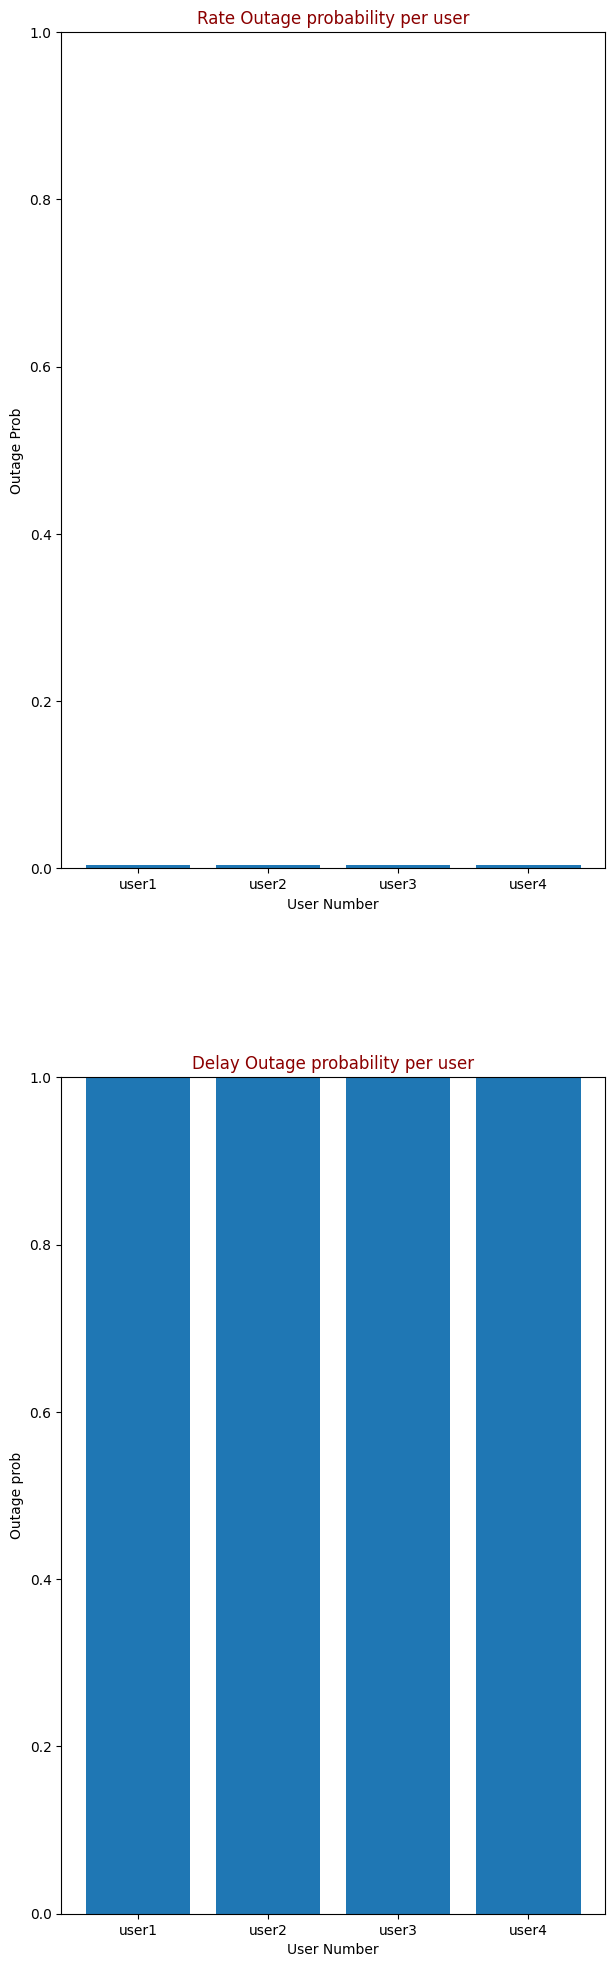

In [30]:
convergence = 25 ## Résultats après convergence (ici après l'episode 25)

average_rate_outage = np.mean(rate_outage[convergence:], axis = 0)
average_delay_outage = np.mean(delay_outage[convergence:], axis = 0)
print(average_rate_outage)
print(average_delay_outage)
print(np.mean(average_rate_outage))
print(np.mean(average_delay_outage))
fig = plt.figure()

idx = np.arange(K)

plt.subplot(211)
plt.bar(idx, average_rate_outage)
plt.ylim(0,1)
plt.xticks(idx, [f'user{i}' for i in range(1, K + 1)])
plt.title('Rate Outage probability per user', color = 'darkred')
plt.ylabel('Outage Prob')
plt.xlabel('User Number')

plt.subplot(212)
plt.bar(idx, average_delay_outage)
plt.ylim(0,1)
plt.xticks(idx, [f'user{i}' for i in range(1, K + 1)])
plt.title('Delay Outage probability per user', color = 'darkred')
plt.ylabel('Outage prob')
plt.xlabel('User Number')

plt.subplots_adjust(top=4, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Centralized/AvgvRew_Ternary.png'

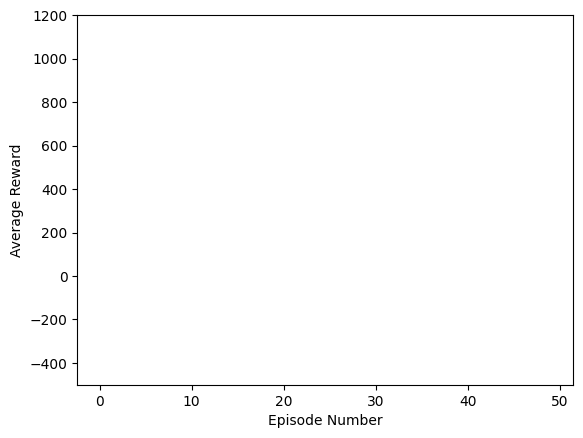

In [31]:
## Ex. pour sauvegarder une figure

plt.plot(avg_reward_history)
plt.ylim(-500, 1200)
plt.ylabel('Average Reward')
plt.xlabel('Episode Number')

plt.savefig('Figures/Centralized/AvgvRew_Ternary.png', dpi = 300)